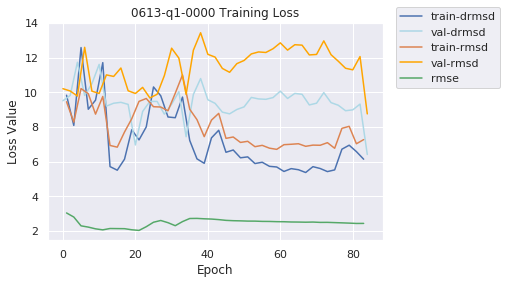

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import os
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

def get_title(filename):
    """
     >>> get_title("logs/0613/0613-q1-0000.train")
     '0613-q1-0000'
     """
    return os.path.splitext(os.path.basename(filename))[0]
def get_df_from_file(f):
    df = pd.read_csv(f)
    df = df[df["is_end_of_epoch"]].reset_index()
    return df

result_files = sorted(glob("logs/*.train"))[:300]
titles = [get_title(f) for f in result_files]
dfes = (get_df_from_file(f) for f in result_files)

def do_plot(df, title):
    dfval = df[df["is_val"]]
    dftrain = df[df["is_val"] != True]
    sns.lineplot(x=dftrain.index, y="drmsd", data=dftrain, label="train-drmsd")
    sns.lineplot(x=dfval.index, y="drmsd", data=dfval, label="val-drmsd",color="lightblue")
    sns.lineplot(x=dftrain.index, y="rmsd", data=dftrain, label="train-rmsd")
    sns.lineplot(x=dfval.index, y="rmsd", data=dfval, label="val-rmsd", color="orange")
    sns.lineplot(x=dftrain.index, y="rmse", data=dftrain, label="rmse")
    plt.ylabel("Loss Value")
    plt.xlabel("Epoch")
    plt.legend(loc=(1.04,.7))
    plt.title("{} Training Loss".format(title))
#     plt.savefig("../figs/transtrain.pdf", pad_inches=1, bbox_inches="tight")

do_plot(get_df_from_file(result_files[0]), titles[0])

In [86]:
def get_best_validation_train_row_from_df(df):
    cols = ["drmsd", "rmse", "rmsd", "combined"]
    best_crit = "rmsd"
    # Separate valid and training losses
    dfval = df[df["is_val"]]
    # Select best row based on criteria
    val_row = dfval[dfval[best_crit] == dfval[best_crit].min()][cols]
    val_row.columns = [str(c) + "-val" for c in val_row.columns]
    train_row = df.iloc[dfval[dfval[best_crit] == dfval[best_crit].min()].index -1][cols]
    train_row.columns = [str(c) + "-train" for c in train_row.columns]
    train_row.index = val_row.index
    best_row = pd.concat([train_row, val_row], axis=1)
    epoch_time = dfval.iloc[1].time - dfval.iloc[0].time
    best_row["epoch_time"] = epoch_time
    return best_row

In [87]:
get_best_validation_train_row_from_df(df)

,drmsd-train,rmse-train,rmsd-train,combined-train,drmsd-val,rmse-val,rmsd-val,combined-val,epoch_time
84,6.138524,2.43822,7.268008,1.869887,6.410983,2.433597,8.750607,1.881285,0.0


In [124]:
files = glob("logs/*.train")
def work(filename):
    mydf = get_df_from_file(filename)
    row = get_best_validation_train_row_from_df(mydf)
    row["name"] = get_title(filename)
    row["cmd_line"] = get_cmd_line_args_from_name(row["name"].tolist()[0], "../../cluster/190613.txt")
    return row
   

In [122]:
import multiprocessing

In [125]:
with multiprocessing.Pool(10) as p:
    results = p.map(work, files)

In [126]:
results[0]

,drmsd-train,rmse-train,rmsd-train,combined-train,drmsd-val,rmse-val,rmsd-val,combined-val,epoch_time,name,cmd_line
278,4.104161,1.743227,5.977197,1.01622,6.34181,1.799151,8.400863,1.2056,0.0,0613-q1-0073,python train.py data/data_190613_query1.tch 06...


In [96]:
final = pd.concat(results).sort_values("drmsd-val")

In [98]:
final.to_csv("results.csv", index=False)

In [99]:
cmds = open("../../cluster/190613.txt", "r").readlines()

In [108]:
results[0].name.tolist()[0]

'0613-q1-0073'

In [115]:
def get_cmd_line_args_from_name(model_name, cmd_file):
    with open(cmd_file,'r') as f:
        for line in f:
            if model_name in line:
                return line

In [116]:
get_cmd_line_args_from_name('0613-q1-0073', "../../cluster/190613.txt")

'python train.py data/data_190613_query1.tch 0613-q1-0073 -e 1000 -b 2 -cl -dm 16 --early_stopping 30 -nh 1 -nl 1 -dk 8 -dv 8  -lr 0.001 -do 0\n'

In [111]:
!grep 0613-q1-0073 ../../cluster/190613.txt

python train.py data/data_190613_query1.tch 0613-q1-0073 -e 1000 -b 2 -cl -dm 16 --early_stopping 30 -nh 1 -nl 1 -dk 8 -dv 8  -lr 0.001 -do 0


In [ ]:
import subprocess
